In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from PIL import Image


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [3]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [5]:
# Set the individual paths to your datasets
train_dir = "/content/drive/MyDrive/Trim_dataset/Dataset/Train"
val_dir   = "/content/drive/MyDrive/Trim_dataset/Dataset/Validation"
test_dir  = "/content/drive/MyDrive/Trim_dataset/Dataset/Test"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Class names (assumes same class folders in each dataset)
class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['Fake', 'Real']


In [11]:
from torchvision.models import resnet18

def build_model():
    model = resnet18(pretrained=True)
    for param in model.layer1.parameters():
        param.requires_grad = False  # Freeze shallow layers (optional)

    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(num_features, 2)
    )
    return model.to(device)

model = build_model()


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)


In [13]:
def train_model(model, train_loader, val_loader, epochs=15, patience=3):
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct = 0.0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / len(train_dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                val_loss += criterion(outputs, labels).item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pt")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⏹️ Early stopping triggered.")
                break

    # Load the best model
    model.load_state_dict(torch.load("best_model.pt"))
    return train_losses, val_losses, train_accs, val_accs


In [14]:
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, epochs=5, patience=2)


Epoch [1/5] - Train Loss: 0.3567, Train Acc: 83.89%, Val Loss: 0.9191, Val Acc: 81.41%
Epoch [2/5] - Train Loss: 0.1220, Train Acc: 94.86%, Val Loss: 0.8686, Val Acc: 76.60%
Epoch [3/5] - Train Loss: 0.1121, Train Acc: 95.97%, Val Loss: 0.9976, Val Acc: 75.96%
Epoch [4/5] - Train Loss: 0.0628, Train Acc: 97.50%, Val Loss: 2.3175, Val Acc: 58.97%
⏹️ Early stopping triggered.


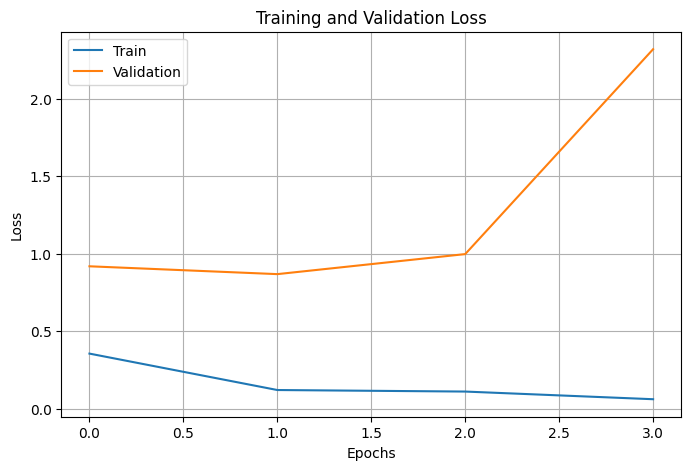

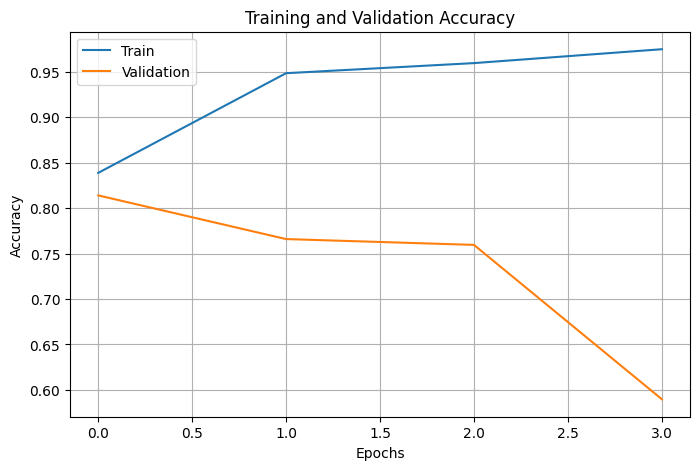

In [15]:
def plot_curves(train_values, val_values, ylabel, title):
    plt.figure(figsize=(8, 5))
    plt.plot(train_values, label="Train")
    plt.plot(val_values, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()

plot_curves(train_losses, val_losses, "Loss", "Training and Validation Loss")
plot_curves(train_accs, val_accs, "Accuracy", "Training and Validation Accuracy")


In [16]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = correct / len(loader.dataset)
    return acc, all_preds, all_labels

test_acc, y_pred, y_true = evaluate(model, test_loader)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")



✅ Test Accuracy: 72.78%



✅ Test Loss: 0.7700
✅ Test Accuracy: 72.78%


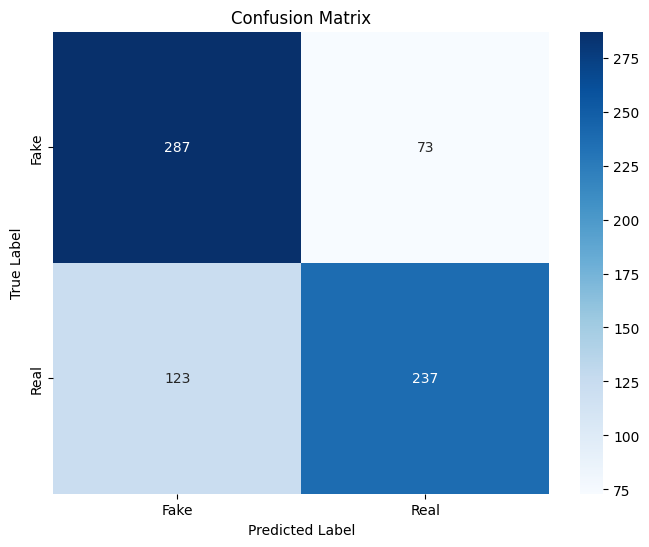


📊 Classification Report:
              precision    recall  f1-score   support

        Fake       0.70      0.80      0.75       360
        Real       0.76      0.66      0.71       360

    accuracy                           0.73       720
   macro avg       0.73      0.73      0.73       720
weighted avg       0.73      0.73      0.73       720



In [24]:
from sklearn.metrics import classification_report

def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            correct += (preds == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_acc = correct / len(test_loader.dataset)

    print(f"\n✅ Test Loss: {test_loss:.4f}")
    print(f"✅ Test Accuracy: {test_acc*100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    return test_acc

# Run the evaluation
test_accuracy = evaluate_model(model, test_loader)


In [18]:
def predict_image(model, image_path):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    input_tensor = val_test_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.nn.functional.softmax(output[0], dim=0)
        predicted_class = torch.argmax(probs).item()
        confidence = probs[predicted_class].item()

    plt.imshow(image)
    plt.title(f"Predicted: {class_names[predicted_class]} ({confidence*100:.2f}%)")
    plt.axis('off')
    plt.show()


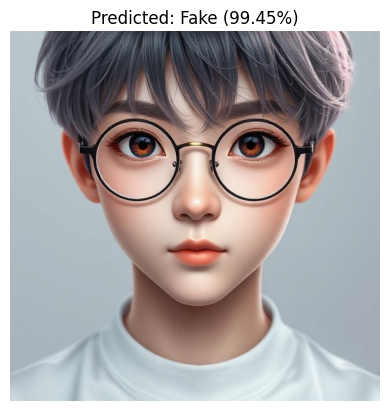

In [19]:
# Replace with an actual image path from your test dataset
predict_image(model, "/content/drive/MyDrive/AI IMAGE 1.jpeg")


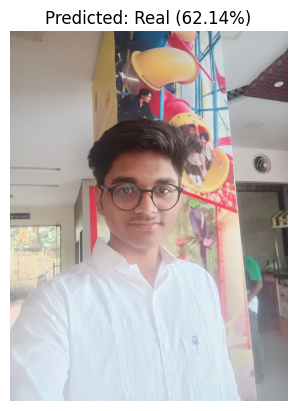

In [21]:
# Replace with an actual image path from your test dataset
predict_image(model, "/content/drive/MyDrive/IMG20230114074618 (1).jpg")


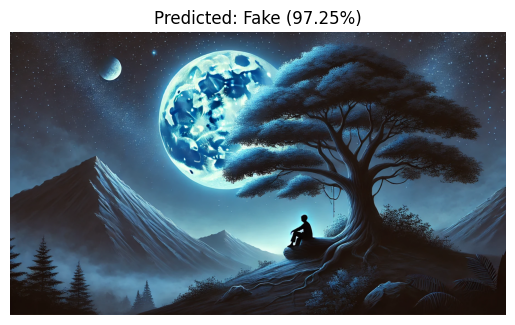

In [20]:
# Replace with an actual image path from your test dataset
predict_image(model, "/content/drive/MyDrive/wallpaper night sky and boy.webp")


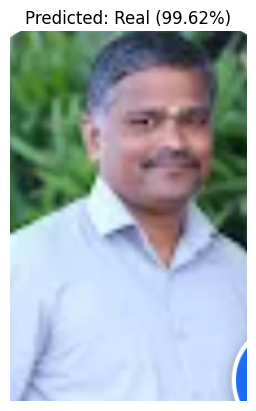

In [22]:
# Replace with an actual image path from your test dataset
predict_image(model, "/content/Screenshot 2025-04-14 215701.png")


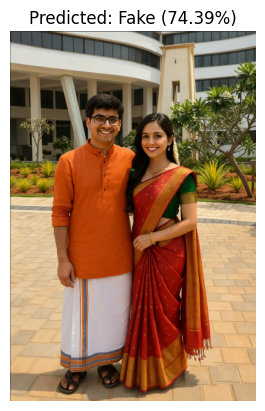

In [23]:
# Replace with an actual image path from your test dataset
predict_image(model, "/content/Screenshot 2025-04-08 003725.png")


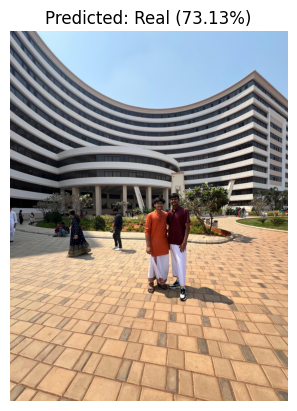

In [27]:
# Replace with an actual image path from your test dataset
predict_image(model, "/content/IMG-20250307-WA0071.jpg")


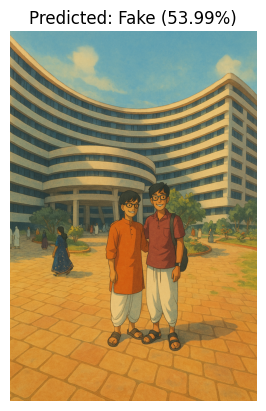

In [28]:
# Replace with an actual image path from your test dataset
predict_image(model, "/content/ChatGPT Image Apr 14, 2025, 10_19_31 PM.png")
